# Which is the fastest axis of an array?

I'd like to know: which axes of a NumPy array are fastest to access?

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## A tiny example

In [2]:
a = np.arange(9).reshape(3, 3)
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [3]:
' '.join(str(i) for i in a.ravel(order='C'))

'0 1 2 3 4 5 6 7 8'

In [4]:
' '.join(str(i) for i in a.ravel(order='F'))

'0 3 6 1 4 7 2 5 8'

## A seismic volume

In [5]:
volume = np.load('data/F3_volume_3x3_16bit.npy')

In [6]:
volume.shape

(194, 299, 451)

Let's look at how the indices vary:

In [7]:
idx = np.indices(volume.shape)

In [9]:
idx.shape

(3, 194, 299, 451)

We can't easily look at the indices for 190 &times; 190 &times; 190 samples (6 859 000 samples). So let's look at a small subset: 5 &times; 5 &times; 5 = 125 samples. We can make a plot of how the indices vary in each direction. For C-ordering, the indices on axis 0 vary slowly: they start at 0 and stay at 0 for 25 samples; then they increment by one. So if we ask for all the data for which axis 0 has index 2 (say), the computer just has to retrieve a contiguous chunk of memory and it gets all the samples. 

On the other hand, if we ask for all the samples for which axis 2 has index 2, we have to retrieve non-contiguous samples from memory, effectively opening a lot of memory 'drawers' and taking one pair of socks out of each one.

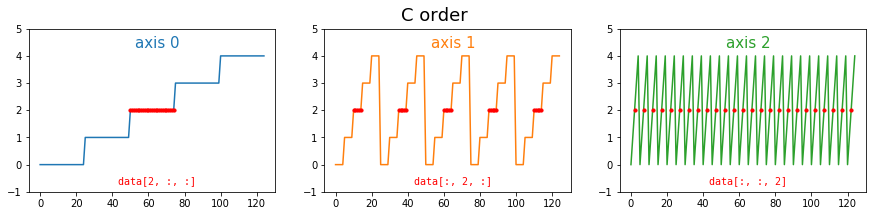

In [10]:
from matplotlib.font_manager import FontProperties

annot = ['data[2, :, :]', 'data[:, 2, :]', 'data[:, :, 2]']
mono = FontProperties()
mono.set_family('monospace')

fig, axs = plt.subplots(ncols=3, figsize=(15,3), facecolor='w')

for i, ax in enumerate(axs):
    data = idx[i, :5, :5, :5].ravel(order='C')
    ax.plot(data, c=f'C{i}')
    ax.scatter(np.where(data==2), data[data==2], color='r', s=10, zorder=10)
    ax.text(65, 4.3, f'axis {i}', color=f'C{i}', size=15, ha='center')
    ax.text(65, -0.7, annot[i], color='red', size=12, ha='center', fontproperties=mono)
    ax.set_ylim(-1, 5)
_ = plt.suptitle("C order", size=18)
plt.savefig('/home/matt/Pictures/3d-array-corder.png')

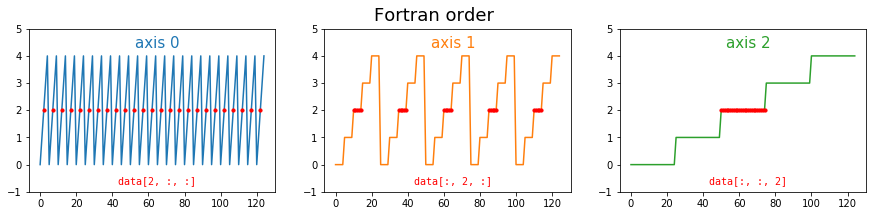

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(15,3), facecolor='w')

for i, ax in enumerate(axs):
    data = idx[i, :5, :5, :5].ravel(order='F')
    ax.plot(data, c=f'C{i}')
    ax.scatter(np.where(data==2), data[data==2], color='r', s=10, zorder=10)
    ax.text(65, 4.3, f'axis {i}', color=f'C{i}', size=15, ha='center')
    ax.text(65, -0.7, annot[i], color='red', size=12, ha='center', fontproperties=mono)
    ax.set_ylim(-1, 5)
_ = plt.suptitle("Fortran order", size=18)
plt.savefig('/home/matt/Pictures/3d-array-forder.png')

At the risk of making it more confusing, it might help to look at the plots together. Shown here is the C ordering:

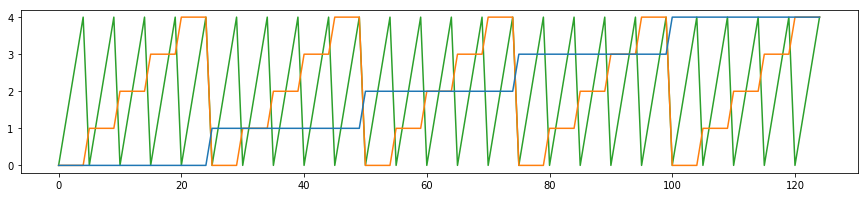

In [12]:
plt.figure(figsize=(15,3))
plt.plot(idx[0, :5, :5, :5].ravel(), zorder=10)
plt.plot(idx[1, :5, :5, :5].ravel(), zorder=9)
plt.plot(idx[2, :5, :5, :5].ravel(), zorder=8)

This organization is reflected in `ndarray.strides`, which tells us how many bytes must be traversed to get to the next index in each axis. Each 2-byte step through memory gets me to the next index in axis 2, but I must strude 72200 bytes to get to the next index of axis 0:

In [13]:
volume.strides

(269698, 902, 2)

## Aside: figure for blog post

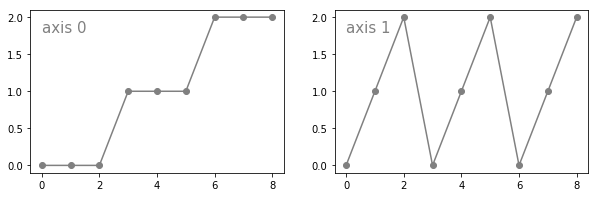

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3), facecolor='w')

for i, ax in enumerate(axs):
    data = idx[i, :3, :3, 0].ravel(order='C')
    ax.plot(data, 'o-', c='gray')
    ax.text(0, 1.8, f'axis {i}', color='gray', size=15, ha='left')
plt.savefig('/home/matt/Pictures/2d-array-corder.png')

## Accessing the seismic data

Let's make all the dimensions the same, to avoid having to slice later. I'll make a copy, otherwise we'll have a view of the original array. 

Alternatively, change the shape here to see effect of small dimensions, eg try `volume = volume[:10, :290, :290]` with C ordering.

In [15]:
volume = volume[:190, :190, :190].copy()

In [16]:
def get_slice_3d(volume, x, axis, n=None):
    """
    Naive function... but only works on 3 dimensions.
    NB Using ellipses slows down last axis.
    """
    # Force cube shape
    if n is None and not np.sum(np.diff(volume.shape)):
        n = np.min(volume.shape)
    if axis == 0:
        data = volume[x, :n, :n]
    if axis == 1:
        data = volume[:n, x, :n]
    if axis == 2:
        data = volume[:n, :n, x]
    return data + 1

In [17]:
%timeit get_slice_3d(volume, 150, axis=0)
%timeit get_slice_3d(volume, 150, axis=1)
%timeit get_slice_3d(volume, 150, axis=2)

18.1 µs ± 3.65 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
43.3 µs ± 7.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
136 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Let's check that changing the memory layout to Fortran ordering makes the last dimension fastest:

In [18]:
volumef = np.asfortranarray(volume)

In [19]:
%timeit get_slice_3d(volumef, 150, axis=0)
%timeit get_slice_3d(volumef, 150, axis=1)
%timeit get_slice_3d(volumef, 150, axis=2)

131 µs ± 5.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
36.6 µs ± 762 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
23.9 µs ± 766 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Axes 0 and 1 are > 10 times faster than axis 2.

What about if we do something like take a Fourier transform over the first axis?

In [20]:
from scipy.signal import welch

In [21]:
%timeit s = [welch(tr, fs=500) for tr in volume[:, 10]]

/home/matt/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 190, using nperseg = 190
  .format(nperseg, input_length))


32 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit s = [welch(tr, fs=500) for tr in volumef[:, 10]]

/home/matt/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 190, using nperseg = 190
  .format(nperseg, input_length))


38.2 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


No practical difference. Hm.

I'm guessing this is because the DFT takes way longer than the data access.

In [23]:
del(volume)
del(volumef)

## Fake data in _n_ dimensions

Let's make a function to generate random data in any number of dimensions.

Be careful: these volumes get big really quickly!

In [24]:
def makend(n, s, equal=True, rev=False, fortran=False):
    """
    Make an n-dimensional hypercube of randoms.
    """
    if equal:
        incr = np.zeros(n, dtype=int)
    elif rev:
        incr = list(reversed(np.arange(n)))
    else:
        incr = np.arange(n)
    shape = incr + np.ones(n, dtype=int)*s
    a = np.random.random(shape)
    m = f"Shape: {tuple(shape)}    "
    m += f"Memory: {a.nbytes/1e6:.0f}MB    "
    m += f"Order: {'F' if fortran else 'C'}"
    print (m)
    if fortran:
        return np.asfortranarray(a)
    else:
        return a

I tried implementing this as a context manager, so you wouldn't have to delete the volume each time after using it. I tried the `@contextmanager` decorator, and I tried making a class with `__enter__()` and `__exit__()` methods. Each time, I tried putting the `del` command as part of the exit routine. They both worked fine... except they did not delete the volume from memory. 

## 2D data

In [25]:
def get_slice_2d(volume, x, axis, n=None):
    """
    Naive function... but only works on 2 dimensions.
    """
    if n is None and not np.sum(np.diff(volume.shape)):
        n = np.min(volume.shape)
    if axis == 0:
        data = volume[x, :n]
    if axis == 1:
        data = volume[:n, x]
    return data + 1

In [26]:
dim = 2

v = makend(dim, 6000, fortran=False)
for n in range(dim):
    %timeit get_slice_2d(v, 3001, n)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: C
19.9 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
73.7 µs ± 5.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
dim = 2

v = makend(dim, 6000, fortran=True)
for n in range(dim):
    %timeit get_slice_2d(v, 3001, n)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: F
71.9 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
29.8 µs ± 2.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


This has been between 3.3 and 12 times faster.

## 1D convolution on an array

In [28]:
def convolve(data, kernel=np.arange(10), axis=0):
    func = lambda tr: np.convolve(tr, kernel, mode='same')
    return np.apply_along_axis(func, axis=axis, arr=data)

In [29]:
dim = 2

v = makend(dim, 6000, fortran=False)
%timeit convolve(v, axis=0)
%timeit convolve(v, axis=1)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: C
705 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
301 ms ± 6.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
dim = 2

v = makend(dim, 6000, fortran=True)
%timeit convolve(v, axis=0)
%timeit convolve(v, axis=1)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: F
301 ms ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
698 ms ± 67.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Speed is double on fast axis, i.e. second axis on default C order.

## `np.mean()` across axes

Let's try taking averages across different axes. In C order it should be faster to get the `mean` on `axis=1` because that involves getting the rows:

In [31]:
a = [[ 2,  4],
     [10, 20]]

np.mean(a, axis=0), np.mean(a, axis=1)

(array([ 6., 12.]), array([ 3., 15.]))

Let's see how this looks on our data:

In [32]:
dim = 2

v = makend(dim, 6000, fortran=False)
%timeit np.mean(v, axis=0)
%timeit np.mean(v, axis=1)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: C
24.9 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.5 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
dim = 2

v = makend(dim, 6000, fortran=True)
%timeit np.mean(v, axis=0)
%timeit np.mean(v, axis=1)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: F
24.4 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.9 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We'd expect the difference to be even more dramatic with `median` because it has to sort every row or column:

In [34]:
v = makend(dim, 6000, fortran=False)
%timeit np.median(v, axis=0)
%timeit np.median(v, axis=1)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: C
1.49 s ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
671 ms ± 9.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
v = makend(dim, 6000, fortran=False)
%timeit v.mean(axis=0)
%timeit v.mean(axis=1)
del v

Shape: (6000, 6000)    Memory: 288MB    Order: C
32.5 ms ± 721 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.2 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3D arrays

In a nutshell:

C order: first axis is fastest, last axis is slowest; factor of two between others.

Fortran order: last axis is fastest, first axis is slowest; factor of two between others.

In [36]:
dim = 3

v = makend(dim, 600)
for n in range(dim):
    %timeit get_slice_3d(v, 201, n)
del v

Shape: (600, 600, 600)    Memory: 1728MB    Order: C
303 µs ± 62.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
958 µs ± 103 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.07 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Non-equal axes doesn't matter.

In [37]:
dim = 3

v = makend(dim, 600, equal=False, rev=True)
for n in range(dim):
    %timeit get_slice_3d(v, 201, n)
del v

Shape: (602, 601, 600)    Memory: 1737MB    Order: C
427 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
882 µs ± 27.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
8.85 ms ± 398 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Fortran order results in a fast last axis, as per. But the middle axis is pretty fast too.

In [38]:
dim = 3

v = makend(dim, 600, fortran=True)
for n in range(dim):
    %timeit get_slice_3d(v, 201, n)
del v

Shape: (600, 600, 600)    Memory: 1728MB    Order: F
8.92 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
848 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
442 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For C ordering, the last dimension is more than 20x slower than the other two.

## 4 dimensions

Axes 0 and 1 are fast (for C ordering), axis 2 is half speed, axis 3 is ca. 15 times slower than fast axis.

In [39]:
def get_slice_4d(volume, x, axis, n=None):
    """
    Naive function... but only works on 4 dimensions.
    """
    if n is None and not np.sum(np.diff(volume.shape)):
        n = np.min(volume.shape)
    if axis == 0:
        data = volume[x, :n, :n, :n]
    if axis == 1:
        data = volume[:n, x, :n, :n]
    if axis == 2:
        data = volume[:n, :n, x, :n]
    if axis == 3:
        data = volume[:n, :n, :n, x]
    return data + 1

In [40]:
dim = 4

v = makend(dim, 100, equal=True)
for n in range(dim):
    %timeit get_slice_4d(v, 51, n)
del v

Shape: (100, 100, 100, 100)    Memory: 800MB    Order: C
1.64 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.75 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.4 ms ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.1 ms ± 692 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
dim = 4

v = makend(dim, 100, equal=True, fortran=True)
for n in range(dim):
    %timeit get_slice_4d(v, 51, n)
del v

Shape: (100, 100, 100, 100)    Memory: 800MB    Order: F
22.5 ms ± 3.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.23 ms ± 81.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.7 ms ± 27.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.63 ms ± 55.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 5 dimensions

We are taking 4-dimensional hyperplanes from a 5-dimensional hypercube. 

Axes 0 and 1 are fast, axis 2 is half speed, axis 3 is quarter speed, and the last axis is about 5x slower than that.

In [42]:
def get_slice_5d(volume, x, axis, n=None):
    """
    Naive function... but only works on 5 dimensions.
    """
    if n is None and not np.sum(np.diff(volume.shape)):
        n = np.min(volume.shape)
    if axis == 0:
        data = volume[x, :n, :n, :n, :n]
    if axis == 1:
        data = volume[:n, x, :n, :n, :n]
    if axis == 2:
        data = volume[:n, :n, x, :n, :n]
    if axis == 3:
        data = volume[:n, :n, :n, x, :n]
    if axis == 4:
        data = volume[:n, :n, :n, :n, x]
    return data + 1

In [43]:
dim = 5

v = makend(dim, 40)
for n in range(dim):
    %timeit get_slice_5d(v, 21, n)
del v

Shape: (40, 40, 40, 40, 40)    Memory: 819MB    Order: C
4.21 ms ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.71 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.14 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.2 ms ± 2.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
dim = 5

v = makend(dim, 40, fortran=True)
for n in range(dim):
    %timeit get_slice_5d(v, 21, n)
del v

Shape: (40, 40, 40, 40, 40)    Memory: 819MB    Order: F
48.6 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.2 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.06 ms ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.47 ms ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.82 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


What about when we're doing something like getting the mean on an array?

In [45]:
dim = 5

v = makend(dim, 40, fortran=True)
for n in range(dim):
    %timeit np.mean(v, axis=n)
del v

Shape: (40, 40, 40, 40, 40)    Memory: 819MB    Order: F
128 ms ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
105 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.1 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
89 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
110 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 6 dimensions and beyond

In general, first _n_/2 dimensions are fast, then gets slower until last dimension is several (5-ish) times slower than the first.

In [46]:
def get_slice_6d(volume, x, axis, n=None):
    """
    Naive function... but only works on 6 dimensions.
    """
    if n is None and not np.sum(np.diff(volume.shape)):
        n = np.min(volume.shape)
    if axis == 0:
        data = volume[x, :n, :n, :n, :n, :n]
    if axis == 1:
        data = volume[:n, x, :n, :n, :n, :n]
    if axis == 2:
        data = volume[:n, :n, x, :n, :n, :n]
    if axis == 3:
        data = volume[:n, :n, :n, x, :n, :n]
    if axis == 4:
        data = volume[:n, :n, :n, :n, x, :n]
    if axis == 5:
        data = volume[:n, :n, :n, :n, :n, x]
    return data + 1

In [47]:
dim = 6

v = makend(dim, 23)
for n in range(dim):
    %timeit get_slice_6d(v, 12, n)
del v

Shape: (23, 23, 23, 23, 23, 23)    Memory: 1184MB    Order: C
26.6 ms ± 498 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.2 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.5 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
44.9 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
113 ms ± 5.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
